## CNN-GRU

### This code is only a generalized code. User can alter the code according toh the requirements.
## The result obtained are a result of proper coding of the problem. The code is well commented and well structured.

### This file contains code for classification of all 11 for a single subject
### Parameters
    Batch size = 32
    epochs = 30
    folds = 10
    Hidden size = 128
    Sequence length = 100


In [1]:
# Import necessary libraries
import torch
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize



In [2]:

# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:

# Define paths and constants
base_path = 'paste the path here'

subjects = ['S4']

tasks = ['list all the task']

sessions = ['S1', 'S2', 'S3']

lookback = 100
batch_size = 32
num_classes = 11
input_channels = 20
sequence_length = 100
hidden_size = 200
num_epochs = 60
num_folds = 10


In [4]:

# %%
# Define the model
class EEGCNN_GRU(nn.Module):
    def __init__(self, input_channels, sequence_length, hidden_size, num_classes):
        super(EEGCNN_GRU, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, 3)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 64, 3)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 64, 3)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.5)
        self.maxpool = nn.MaxPool1d(2)
        self.gru = nn.GRU(64, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.elu(self.bn1(self.conv1(x)))
        x = F.elu(self.bn2(self.conv2(x)))
        x = F.elu(self.bn3(self.conv3(x)))
        x = self.dropout1(x)
        x = self.maxpool(x)
        x = x.permute(0, 2, 1)
        x, _ = self.gru(x)
        x = self.dropout2(x)
        x = x[:, -1, :]
        x = F.elu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x


In [5]:

# Function to create dataset
def create_dataset(df, lookback, label):
    df = df.to_numpy()
    X, y = [], []
    for i in range(0, len(df) - lookback + 1, lookback):
        X.append(df[i:i + lookback])
        y.append(label)
    return np.array(X), np.array(y)


In [ ]:

# Function to preprocess data for a single subject
def preprocess_subject_data(path, tasks, sessions, lookback):
    Data_MI = pd.DataFrame()
    Data_RE = pd.DataFrame()
    Data_MM = pd.DataFrame()
    Data_MI2 = pd.DataFrame()
    Data_MM2 = pd.DataFrame()
    Data_MM3 = pd.DataFrame()
    Data_MI3 = pd.DataFrame()
    Data_MI4 = pd.DataFrame()
    Data_REC = pd.DataFrame()
    Data_VEP3 = pd.DataFrame()
    Data_VEP4 = pd.DataFrame()

    for sess in sessions:
        for task in tasks:
            data = pd.read_csv(f'{path}/{task}/{sess}.csv')
            if task == 'MI1':
                Data_MI = pd.concat([Data_MI, data], ignore_index=True)
            elif task == 'REO':
                Data_RE = pd.concat([Data_RE, data], ignore_index=True)
                """
                list all the tasks likewise here
                """

    Data_MI.drop(['time'], axis=1, inplace=True)
    """
                drop the irrelevant columns likewise here
                """

    normalized_MI = normalize(Data_MI, norm='max', axis=0)


    Data_MI = pd.DataFrame(normalized_MI, columns=Data_MI.columns)


    X_RE, y_RE = create_dataset(Data_RE, lookback, 0)


    return X_RE, y_RE


In [7]:
def shuffle_data(X, y):
    indices = np.random.permutation(len(X))
    return X[indices], y[indices]

In [8]:
# Training loop
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    return train_loss, train_accuracy


In [9]:
# Validation loop
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels) 
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    return val_loss, val_accuracy


In [10]:
# Function to plot ROC curve
def plot_roc_curve(y_test_roc, y_score, num_classes):
    # Binarize labels for multi-class ROC
    y_test_bin = label_binarize(y_test_roc, classes=list(range(num_classes)))
    
    plt.figure(figsize=(10, 8))
    
    # Plot ROC curve for each class
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Task {tasks[i]} (AUC = {roc_auc:.2f})')
    
    # Plot settings
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line for random chance
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


In [ ]:

# Function to train and evaluate model for a subject
from sklearn.model_selection import train_test_split
def train_and_evaluate_subject(subject_path):
    X_MI, y_MI, X_RE, y_RE, X_MM, y_MM, X_MM2, y_MM2, X_MI2, y_MI2, X_MM3, y_MM3, X_MI3, y_MI3, X_MI4, y_MI4, X_REC, y_REC, X_VEP3, y_VEP3, X_VEP4, y_VEP4 = preprocess_subject_data(subject_path, tasks, sessions, lookback)

    # Splitting into training and testing sets
    X_train_re, X_test_re, y_train_re, y_test_re = train_test_split(X_RE, y_RE, test_size=0.4, random_state=42, stratify=y_RE)
    



    X_train = np.concatenate((X_train_re, X_train_mm, X_train_mi, X_train_mm2, X_train_mi2, X_train_mm3, X_train_mi3, X_train_mi4, X_train_rec, X_train_vep3, X_train_vep4), axis=0)
    y_train = np.concatenate((y_train_re, y_train_mm, y_train_mi, y_train_mm2, y_train_mi2, y_train_mm3, y_train_mi3, y_train_mi4, y_train_rec, y_train_vep3, y_train_vep4), axis=0)
    X_test = np.concatenate((X_test_re, X_test_mm, X_test_mi, X_test_mm2, X_test_mi2, X_test_mm3, X_test_mi3, X_test_mi4, X_test_rec, X_test_vep3, X_test_vep4), axis=0)
    y_test = np.concatenate((y_test_re, y_test_mm, y_test_mi, y_test_mm2, y_test_mi2, y_test_mm3, y_test_mi3, y_test_mi4, y_test_rec, y_test_vep3, y_test_vep4), axis=0)

    # Shuffle data
    X_train, y_train = shuffle_data(X_train, y_train)
    X_test, y_test = shuffle_data(X_test, y_test)

    # converting into tensors
    X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).long()
    X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).long()

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    model = EEGCNN_GRU(input_channels, sequence_length, hidden_size, num_classes).to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    
    best_val_loss = float('inf')
    best_model_state_dict = None
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []

    ## 10 fold validation
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
        X_train_fold, y_train_fold = X_train[train_index], y_train[train_index]
        X_val_fold, y_val_fold = X_train[val_index], y_train[val_index]

        train_loader_fold = DataLoader(TensorDataset(X_train_fold, y_train_fold), batch_size=batch_size, shuffle=True)
        val_loader_fold = DataLoader(TensorDataset(X_val_fold, y_val_fold), batch_size=batch_size, shuffle=False)
        
        for epoch in range(num_epochs):
            train_loss, train_accuracy = train(model, train_loader_fold, optimizer, criterion, device)
            val_loss, val_accuracy = validate(model, val_loader_fold, criterion, device)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state_dict = model.state_dict()
    

    avg_train_accuracy = np.mean(train_accuracies)
    avg_val_accuracy = np.mean(val_accuracies)
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)

    # Plot training and validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    #### Testing the model
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
    model.load_state_dict(best_model_state_dict)
    torch.save(model.state_dict(), f'{subjects[0]}_model_all_tasks.pth')


    model.eval()
    correct, total = 0, 0
    predicted_labels, true_labels, predicted_probs_list = [], [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            predicted_probs = F.softmax(outputs, dim=1)
            predicted_probs_list.append(predicted_probs.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    
    predicted_probs_np = np.concatenate(predicted_probs_list)
    test_accuracy = 100 * correct / total
    y_score = np.vstack(predicted_probs_list)  # Predicted probabilities as array
    y_test_roc = np.array(true_labels) 

    print(f"Test Accuracy: {test_accuracy:.2f}% ")
    # Metrics calculation
    acc = accuracy_score(true_labels, predicted_labels)
    prec = precision_score(true_labels, predicted_labels, average='weighted')
    rec = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    print(f"Accuracy: {acc}")
    print(f'Precision: {prec}')
    print(f'Recall: {rec}')
    print(f'F1-score: {f1}')



    # confusion matrix and TPR, FPR
    cm = confusion_matrix(true_labels, predicted_labels)
    report = classification_report(true_labels, predicted_labels, target_names=tasks)
    print("Classification Report:\n", report)

    # tn, fp, fn, tp = cm.ravel()
    # tpr = tp / (tp + fn)
    # fpr = fp / (fp + tn)

    # print(f'TPR: {tpr}')
    # print(f'FPR: {fpr}')

    # ROC curve
    # fpr_curve, tpr_curve, thresholds = roc_curve(true_labels, predicted_probs_np[:, 1])
    # auc = roc_auc_score(true_labels, predicted_probs_np[:, 1])
    # print(f'AUC: {auc}')

    # Plot ROC curve
    plot_roc_curve(y_test_roc, y_score, num_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws= {"size":35})
    plt.xlabel('Predicted labels', fontsize=20)
    plt.ylabel('True labels', fontsize=20)
    plt.title(f'Confusion Matrix for {subjects[0]}', fontsize=24)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()


    # plt.figure()
    # plt.plot(fpr_curve, tpr_curve, label=f"ROC Curve (AUC = {auc:.2f})")
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('Receiver Operating Characteristic (ROC) Curve')
    # plt.legend()
    # plt.show()

    return avg_train_accuracy, avg_val_accuracy, avg_train_loss, avg_val_loss, test_accuracy, acc, prec, rec, f1, predicted_labels, true_labels, predicted_probs_np



Processing subject: S4


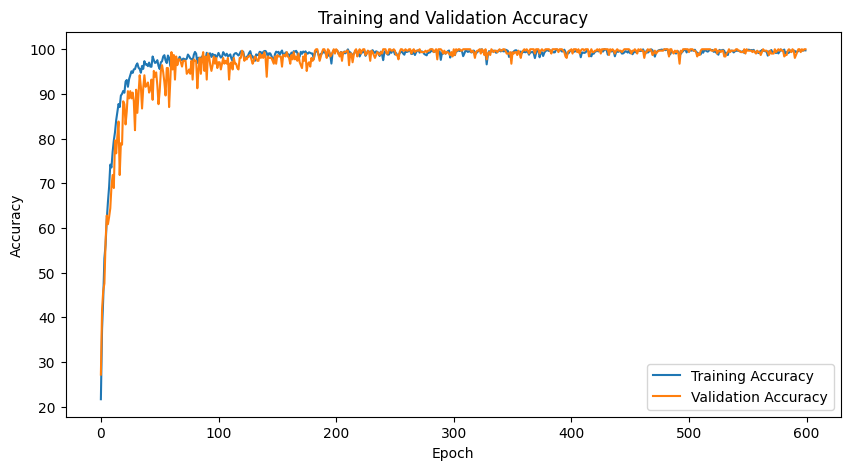

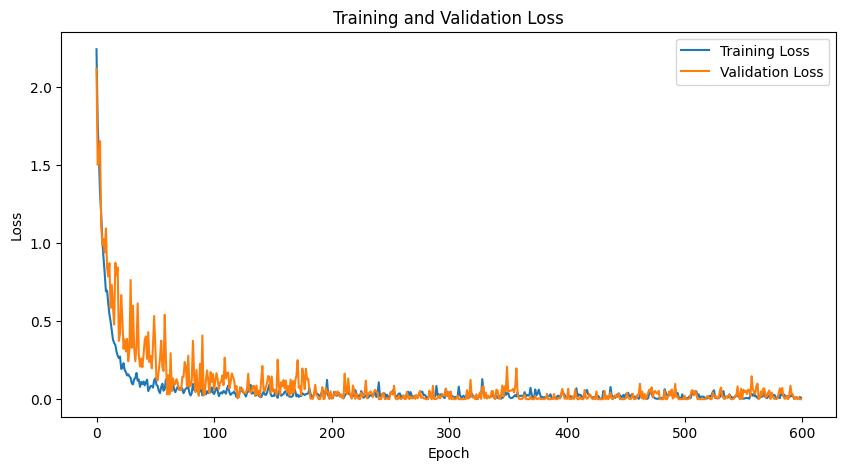

Test Accuracy: 98.64% 
Accuracy: 0.9864209505334627
Precision: 0.9873148974078395
Recall: 0.9864209505334627
F1-score: 0.9864174880687069
Classification Report:
               precision    recall  f1-score   support

         REO       0.99      0.97      0.98       154
         MI1       0.99      0.99      0.99       154
         MM1       0.98      1.00      0.99       154
         MI2       0.99      0.99      0.99       154
         MM2       1.00      0.99      1.00       154
         MI3       0.99      1.00      1.00       154
         MM3       1.00      1.00      1.00       154
         MI4       0.89      0.99      0.94       154
         REC       1.00      0.89      0.94       154
        VEP3       1.00      0.99      1.00       338
        VEP4       1.00      1.00      1.00       338

    accuracy                           0.99      2062
   macro avg       0.98      0.98      0.98      2062
weighted avg       0.99      0.99      0.99      2062



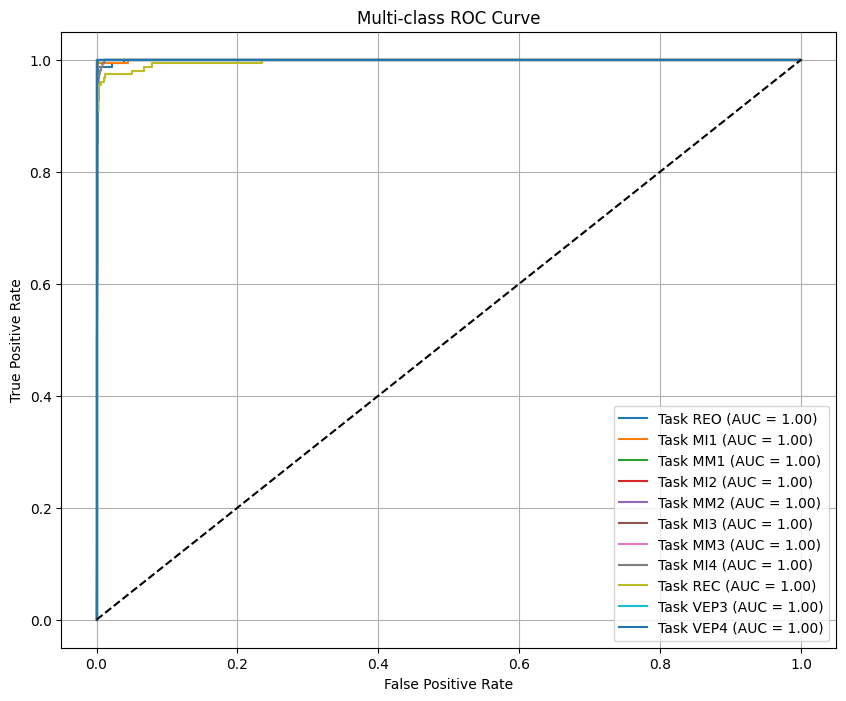

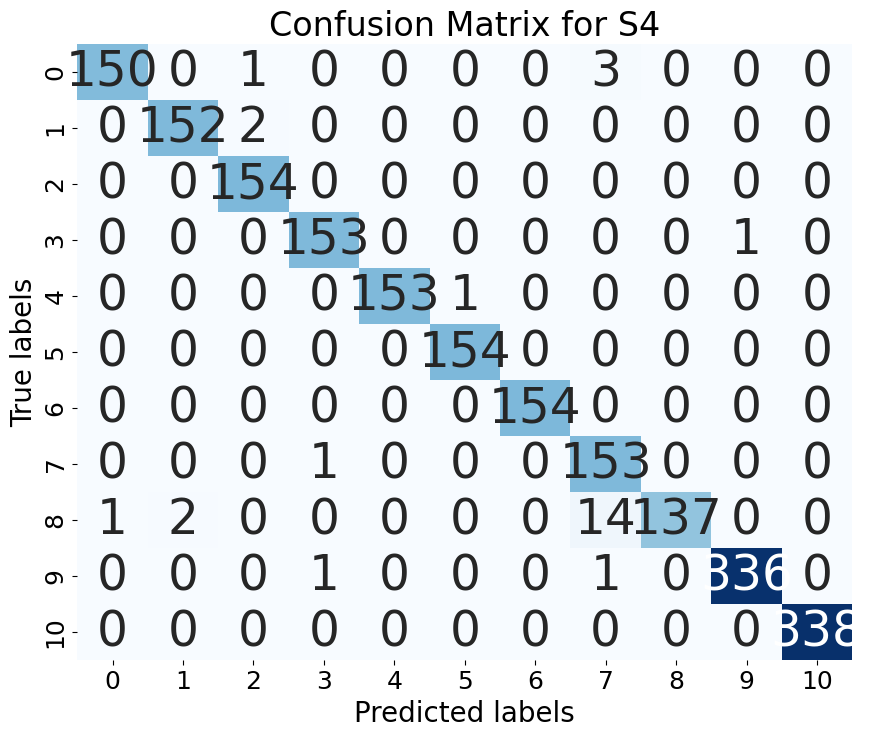

  subject  accuracy  precision    recall  f1_score
0      S4  0.986421   0.987315  0.986421  0.986417


In [12]:

# Main loop to handle all subjects
all_subjects_results = []

for subject in subjects:
    subject_path = f'{base_path}/{subject}'
    print(f"Processing subject: {subject}")
    avg_train_accuracy, avg_val_accuracy, avg_train_loss, avg_val_loss, test_accuracy, acc, prec, rec, f1, predicted_labels, true_labels, predicted_probs_np = train_and_evaluate_subject(subject_path)
    results = {
        'subject': subject,
        'avg_train_accuracy': avg_train_accuracy,
        'avg_train_loss': avg_train_loss,
        'avg_val_accuracy': avg_val_accuracy,
        'avg_val_loss': avg_val_loss,
        'test_accuracy': test_accuracy,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
        # 'tpr': tpr,
        # 'fpr': fpr
        #'predicted_labels': predicted_labels,
        #'true_labels': true_labels,
        #'predicted_probs': predicted_probs_np
    }
    all_subjects_results.append(results)

# Convert results to DataFrame for further analysis
results_df = pd.DataFrame(all_subjects_results)

# Print summary of results
print(results_df[['subject', 'accuracy', 'precision', 'recall', 'f1_score']])

# Optionally save the results to a CSV file
results_df.to_csv(f'ALL_TASKS_CLASSIFICATION_CNN_GRU_{subjects[0]}_with_roc.csv', index=False)
